Import libraries

In [1]:
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import random

import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors as mcolors
from scipy import stats

# import k-means from clustering stage
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import folium # map rendering library
from folium.plugins import HeatMap

print('Libraries imported.')


Libraries imported.


In [2]:
CLIENT_ID = 'X3INNHZFS0RE4YAMNP5CCG4UVUP4S5K1S4NZIIXKHN2UNXJW' # your Foursquare ID
CLIENT_SECRET = '20EOF0IP0MALLD0RO0MM1QOCLEHXC35L4U3JHMETTEF24YJR' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: X3INNHZFS0RE4YAMNP5CCG4UVUP4S5K1S4NZIIXKHN2UNXJW
CLIENT_SECRET:20EOF0IP0MALLD0RO0MM1QOCLEHXC35L4U3JHMETTEF24YJR


In [3]:

def get_colors(n):
    return list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))

In [4]:
def data_features_draw_hist(data,n_bins,nplots,nrows,ncols,Title):
            """Visualization of statistical distributions."""
            np.random.seed(19680801)
            nbins=25
            ntotal=nrows*ncols
            df=data
            dfs=df.describe()
            if nplots <= 7:
                colors = [ic for ic in mcolors.BASE_COLORS.values() if ic !=(1,1,1)]
            else: 
                colors=get_colors(nplots)
         
            columns=df.columns
            
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
            fig.set_canvas(plt.gcf().canvas)
            
         
            for ii,axt,color in zip(range(len(columns)),axs.flat[:nplots],colors):
                    data=df.iloc[:,ii]
                    count,mean,std,min,Q25,Q50,Q75,max=dfs.iloc[:,ii]
                    bins=np.linspace(min,max,100)
                    axt.hist(data.T, n_bins, density=True, histtype='bar', color=color,label='frequency')
                    axt.legend(prop={'size': 10})
                    bin_centers = 0.5*(bins[1:] + bins[:-1])
                    pdf = stats.norm.pdf(bin_centers,mean,std)
                    axt.plot(bin_centers,pdf,color=(0.3,0.5,0.2),lw=2)
            
                    axt.set_title(df.columns[ii])

            for axt in axs.flat[nplots:]:
                        axt.axis('off')

            plt.suptitle(Title)
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            #fig.tight_layout()
            savefig=Title + '.png'
            return fig.savefig(savefig),plt.show()


In [5]:
#Create heatmap with properties
def heatmap(address,zoom_start,prop,ii):
    geolocator = Nominatim(user_agent="to_explorer",timeout=50)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    prop_heat=prop[prop.columns[ii]].values.tolist()
    max_heat=float(prop[prop.columns[ii]].max())
    # create map
    map_heat= folium.Map(location=[latitude, longitude], zoom_start=zoom_start)
    # add markers to the map
    map_properties = HeatMap( list(zip(prop.Latitude.values, prop.Longitude.values, prop_heat)),
                   min_opacity=0.2,
                   max_val=max_heat,
                   radius=17, 
                   blur= 15, 
                   max_zoom=1, 
                 ).add_to(map_heat)
    
    return map_heat


In [6]:
def frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks):
        """From dict with orient='index'"""
        """ y-list of p-matrix of n*2 order """
        X=[]
        Y=[]
        Z=[]
        for elem in y:
            Z.append(elem.index)
            if elem.shape[1] > 1:
                X.append(elem[elem.columns[0]].values)
                Y.append(elem[elem.columns[1]].values)
            else:
                X.append(elem.index)
                Y.append(elem[elem.columns[0]].values)
            
        maxX=max([r.max() for r in Z])+1
        X=pd.DataFrame(X,index=Labels,columns=range(0,maxX)).T
        Y=pd.DataFrame(Y,index=Labels,columns=range(0,maxX)).T
    
        if mapping=='Log':
            Title='Log20 '+Title
            Y=np.log(np.abs(Y))/np.log(20)
        
        Title=Title
        xlabel=xlabel
        ylabel=ylabel
        Linestyle=['-','-.','--',':','--','solid','dashed','dashdot','dotted'] 
        return plot_matrix_matrix(X,Y,Title,xlabel,ylabel,Labels,\
                                            Linestyle,0,mapping,grid,text,boxstyle,xticks,yticks)

In [7]:
def kmeans_clustering_evaluation(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks):
        """From dict with orient='index'"""
        """ y-list of p-matrix of n*2 order """

        R=[]
        Z=[]
        S=[]
        P=[]
        for elem in y:
            Z.append(elem.index)
            R.append(elem[elem.columns[0]][:-2].values)
            # Silhouette coefficient
            S.append(elem.loc[elem.index[-2],elem.columns[0]])   
            P.append(elem.loc[elem.index[-1],elem.columns[0]]) 
        maxZ=max([r.max() for r in Z])-1
    
        # Compute entropy associated to clustering
        Y=pd.DataFrame(R,columns=range(0,maxZ)).T
        W=Y/Y.sum()
        W=W.fillna(1)
        Y=W.apply(lambda x:-sum(x*np.log(x)/np.log(2))) 
        P=pd.DataFrame(P, columns=['Purity'])
        S=pd.DataFrame(S,columns=['Silhouette coef'])
        Y=pd.DataFrame(Y, columns=['Entropy'])
        Y=pd.concat([Y,S,P],axis=1)
    
        # build X
        m,n=Y.shape
        X=np.array(np.ones((m,n)))
        X=np.array(X)
        X=pd.DataFrame(X)

        X.loc[0,:]=0
        X=np.cumsum(X)
        
        
        if mapping=='Log':
            Title='Log20 '+Title
            Y=np.log(np.abs(Y))/np.log(20)
        if mapping =='XLog':
            X=np.log(np.abs(X))/np.log(20)
            xlabel='Log20'+ xlabel
            
        Title=Title
        xlabel=xlabel
        ylabel=ylabel
        Linestyle=['-','-.','--',':','--','solid','dashed','dashdot','dotted'] 

        return Y,plot_matrix_matrix(X,Y,Title,xlabel,ylabel,Labels,Linestyle,0,mapping,grid,text,boxstyle,xticks,yticks)
    

In [8]:
def plot_matrix_matrix(X,Y,Title,xlabel,ylabel,Labels,\
                           Linestyle,kind,scale,grid,text,boxstyle,xticks,yticks):
        """Draw matrix vs matrix."""
        """
        kind of graphic
        0-plot
        1-scatter
        2-stem
        scale of plot
        'equal'
        'Log'
        'semilogy'
        'semilogx'
        'Loglog'
        """
        import matplotlib.pyplot as plt
        from matplotlib import colors as mcolors
        # colors for grahics with matplolib and plotly
        
        colors = [ic for ic in mcolors.BASE_COLORS.values() if ic !=(1,1,1)]
        keys   = [kc  for kc in mcolors.BASE_COLORS.keys() if mcolors.BASE_COLORS[kc]!=(1,1,1)]

        """
        Checking orders of matrices
        """
        if (X.shape[0]!=Y.shape[0] or X.shape[1]!=Y.shape[1]):
                    print("These matrices are not equal order")
    
        Y.iloc[1,:] 
        idx=[X.iloc[:,i].argsort() for i in range(X.shape[1])]
        plt.figure()
        ax=plt.subplot(1,1,1)
        for i,linestyle in enumerate(Linestyle):
            if i in range(X.shape[1]):
                label=Labels[i]

                if kind==0 :
                    if scale=='equal' or 'Log':
                        ax.plot(X.iloc[idx[i],i],Y.iloc[idx[i],i],linestyle=linestyle,linewidth=1.5,label=label,color=colors[i])
                        if len(xticks) > 0:
                            ax.set_xticks(range(len(xticks)))
                            ax.set_xticklabels(xticks)
                            ax.xaxis.set_ticks_position('bottom')
                        if len(yticks) > 0: 
                            ax.set_yticks(range(len(yticks)))
                            ax.set_yticklabels(yticks)
                    elif scale=='semilogy':
                            ax.semilogy(X.iloc[idx[i],i],Y.iloc[idx[i],i],linestyle=linestyle,linewidth=1.5,label=label,color=colors[i])
                    elif scale =='semilogx':
                            ax.semilogx(X.iloc[idx[i],i],Y.iloc[idx[i],i],linestyle=linestyle,linewidth=1.5,label=label,color=colors[i])
                    elif scale =='Loglog':
                            ax.loglog(X.iloc[idx[i],i],Y.iloc[idx[i],i],linestyle=linestyle,linewidth=1.5,label=label,color=colors[i])
                    else:
                         pass
                elif kind==1:
                      ax.scatter(X.iloc[idx[i],i],Y.iloc[idx[i],i],marker=linestyle,label=label,color=colors[i])
                elif kind==2:
                    markerline, stemlines, baseline = ax.stem(X.iloc[idx[i],i],Y.iloc[idx[i],i],'-.',\
                                                             markerfmt=keys[i]+'o',label=label)
                   #ax.setp(baseline, color='r', linewidth=1.5)
                else:
                    pass
            else:
                pass

        ax.legend(prop={'size':10})
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(Title)
        plt.tight_layout(rect=[0, 0, 1, 1])
        plt.grid(grid)
        plt.grid(color=colors[0],linestyle='',linewidth='1')
        if len(text)>0:
              plt.text(0.1, 85.0,text,\
                     {'color': 'k', 'fontsize':10, 'ha': 'left', 'va': 'center',\
                      'bbox': dict(boxstyle=str(boxstyle), fc="w", ec="k", pad=0.3)})

        return plt.show()

In [9]:
boroughs=pd.read_csv("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/Boroughs_london.csv",index_col=0)

Neighbourhoods

In [10]:
neighbourhoods=pd.read_csv('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/neighbourhoods_london.csv',index_col=0)

Centroids


In [11]:
Centroids_N03=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N03.xlsx',index_col=0)
Centroids_b03=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_b03.xlsx',index_col=0)
Centroids_N031=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N031.xlsx',index_col=0)
Centroids_N032=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N032.xlsx',index_col=0)
Centroids_N033=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N033.xlsx',index_col=0)
Centroids_N034=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N034.xlsx',index_col=0)
Centroids_N035=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Centroids_N035.xlsx',index_col=0)

In [12]:
Centroids=[Centroids_N03,Centroids_b03,Centroids_N031,Centroids_N032,Centroids_N033,Centroids_N034,Centroids_N035]

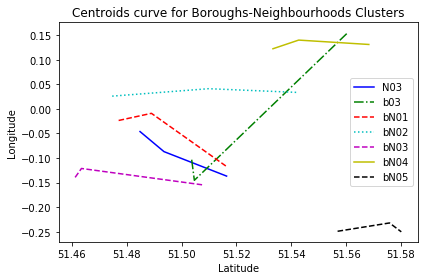

In [13]:
#code to graph a list of dataframes
y=Centroids
xlabel='Latitude'
ylabel='Longitude'
Title='Centroids curve for Boroughs-Neighbourhoods Clusters'
mapping='equal'
grid='False'
text=''
Labels=['N03','b03','bN01','bN02','bN03','bN04','bN05']
boxstyle='square'
xticks=''
yticks=''
frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks)

Kclusters

In [14]:
Kclusters_b03=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_b03.xlsx',index_col=0)
Kclusters_N03=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N03.xlsx',index_col=0)
Kclusters_N031=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N031.xlsx',index_col=0)
Kclusters_N032=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N032.xlsx',index_col=0)
Kclusters_N033=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N033.xlsx',index_col=0)
Kclusters_N034=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N034.xlsx',index_col=0)
Kclusters_N035=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/Kclusters_N035.xlsx',index_col=0)

In [15]:
Kclusters=[Kclusters_N03,Kclusters_b03,Kclusters_N031,Kclusters_N032,Kclusters_N033,Kclusters_N034,Kclusters_N035]

In [16]:
p=len(Kclusters)

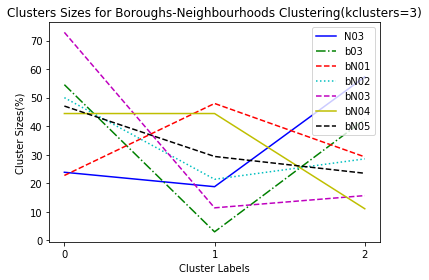

In [17]:
#code to graph a list of dataframes
y=[Kclusters[ii][0:3]/Kclusters[ii][0:3].sum()*100 for ii in range(p)]
xlabel='Cluster Labels'
ylabel='Cluster Sizes(%)'
Title='Clusters Sizes for Boroughs-Neighbourhoods Clustering(kclusters=3)'
mapping='equal'
grid='False'
text=''
Labels=['N03','b03','bN01','bN02','bN03','bN04','bN05']
boxstyle='square'
xticks=range(3)
yticks=''
frame_from_list(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks)

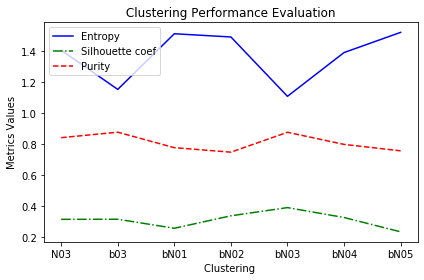

In [18]:
#code to evaluate the performance of clustering
y=Kclusters
xlabel='Clustering '
ylabel='Metrics Values'
Title=' Clustering Performance Evaluation '
mapping='equal'
grid='False'
text=''
Labels=['Entropy','Silhouette coef','Purity']
boxstyle='square'
xticks=('N03','b03','bN01','bN02','bN03','bN04','bN05')
yticks=''
Metrics=kmeans_clustering_evaluation(y,xlabel,ylabel,Title,mapping,grid,text,Labels,boxstyle,xticks,yticks)

In [19]:
# Clustering Performance Evaluation
Metrics[0]

,Entropy,Silhouette coef,Purity
0,1.407517,0.317074,0.843525
1,1.154648,0.317699,0.878788
2,1.513253,0.259599,0.778986
3,1.492614,0.339843,0.750000
4,1.110034,0.392674,0.878261
5,1.392147,0.328880,0.800000
6,1.522190,0.236564,0.758621


In [20]:
df=Metrics[0]
dg=(df['Silhouette coef']*df['Purity'])/df['Entropy']
dg3=pd.DataFrame(dg.values,index=['N03','b03','bN01','bN02','bN03','bN04','bN05'],columns=['kclusters=3'])
dg3=dg3.rename(index={'N03':'N','b03':'b'})

In [21]:
dg5=pd.read_excel('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/dg5.xlsx',index_col=0)
dg5=dg5.rename(index={'N05':'N','b05':'b'})

In [22]:
dg=pd.concat([dg5,dg3],axis=1,sort=True)
dg

,kclusters=5,kclusters=3
N,0.071822,0.190022
b,0.195806,0.241797
bN01,0.090376,0.133635
bN02,0.111473,0.170762
bN03,0.116923,0.310684
bN04,0.156985,0.188992
bN05,0.126407,0.117897


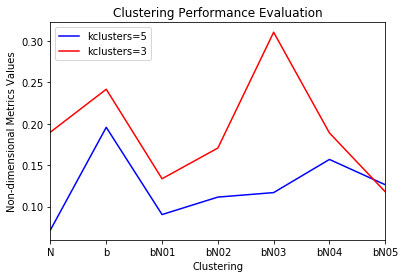

In [23]:
dg.plot(title='Clustering Performance Evaluation',color=['b','r'])
plt.xlabel('Clustering')
plt.ylabel('Non-dimensional Metrics Values')
plt.show()

Identify each neighbourhood with its Cluster Labels

Finally, let's visualize the resulting clusters

address = 'London,UK'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

import random

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters

colors=get_colors(kclusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_neig_merged['Latitude'], London_neig_merged['Longitude'],
                                  London_neig_merged['Neighbourhood'], London_neig_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster-1],
        fill=True,
        #fill_colors=colors[cluster-1],
        fill_colors='white',
        fill_opacity=0.2).add_to(map_clusters)
       
map_clusters


map_clusters.save("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/map_London_bc05_CLUSTER_05.html")

In [24]:
boroughs_grouped=pd.read_excel("/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/RESULTS/London_boroughs_grouped.xlsx", index_col=0)

In [25]:
London_neig_grouped=pd.read_csv('/home/sedna/Downloads/PROJECT-COURSERA-CAPSTONE/DATA/london_neig_grouped_CATEGORY_mean.csv', index_col=0)